In [1]:
import os
import chess
import chess.pgn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

C:\Users\toell\AppData\Local\Temp\ipykernel_32496\773410350.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
if os.getcwd().split('\\')[-1] != 'irl-chess':
    os.chdir('../')

In [16]:
def win_loss_translation(inp):
    if inp[0] == '0':       # White loss
        out = -1
    else:
        if inp[1] == '-':   # White win
            out = 1
        else:               # Draw
            out = 0
    return out

def parse_pgn(game):
    # CHATGPT (Modified)
    outcome_start = game.find("Result") + 8
    outcome_end = outcome_start + 3
    outcome = win_loss_translation(game[outcome_start:outcome_end].strip())

    white_elo_start = game.find("WhiteElo") + 10
    white_elo_end = white_elo_start + game[white_elo_start:].find('"')
    white_elo = int(game[white_elo_start:white_elo_end].strip())

    black_elo_start = game.find("BlackElo") + 10
    black_elo_end = black_elo_start + game[black_elo_start:].find('"')
    black_elo = int(game[black_elo_start:black_elo_end].strip())

    moves = []
    for move in game.split("\n\n")[1].split(' '):
        if '.' not in move:     # Remove numbering
            moves.append(move)
    moves = moves[:-3]          # Remove game result
    
    game_length = len(moves)
    
    return outcome, white_elo, black_elo, game_length, moves

In [17]:
path = 'data/ficsgamesdb_2021_standard_nomovetimes/ficsgamesdb_2021_standard_nomovetimes.pgn'

moves_list = []
data = []

# Read and process the PGN file
with open(path, 'r') as file:
    game = ""
    event_count = 0
    for line in tqdm(file, total=8_936_708):
        game += line
        if 'Event' in line:
            event_count += 1
        if event_count == 2:  # Check if game string is not empty
            outcome, white_elo, black_elo, game_length, moves = parse_pgn(game)
            moves_list.append(moves)
            data.append((outcome, white_elo, black_elo, game_length))
            game = ""
            event_count = 1

100%|██████████| 8936708/8936708 [00:26<00:00, 339633.59it/s]


In [19]:
# Print the first 2 games and their corresponding data
for i in range(2):
    print(f"Moves {i + 1}:\n{moves_list[i]}\nOutcome: {data[i][0]}, White Elo: {data[i][1]}, Black Elo: {data[i][2]}, Game Length: {data[i][3]} moves\n")

Moves 1:
['Nf3', 'e6', 'e3', 'c5', 'c4', 'Nf6', 'Nd4', 'd5', 'Ne2', 'Bd6', 'cxd5', 'Nxd5', 'Nec3', 'Nxc3', 'dxc3', 'O-O', 'Bb5', 'a6', 'Bd3', 'Nc6', 'O-O', 'Ne5', 'Na3', 'Nxd3', 'Nc2', 'Nxc1', 'Rxc1', 'h6', 'e4', 'Qc7', 'Na3', 'Bxh2+', 'Kh1', 'Bf4', 'Kg1', 'Bxc1', 'Qxc1', 'Qe7', 'Rd1', 'e5', 'f3', 'Be6', 'g3', 'b5', 'f4', 'b4', 'fxe5', 'bxa3', 'bxa3', 'Bg4', 'Qb1', 'Qxe5', 'Kg2', 'Bxd1']
Outcome: -1, White Elo: 1720, Black Elo: 1525, Game Length: 54 moves

Moves 2:
['e4', 'e5', 'Nf3', 'Nc6', 'g3', 'Bc5', 'Bg2', 'd6', 'O-O', 'Bg4', 'c3', 'Nge7', 'd3', 'Qd7', 'Nbd2', 'Bh3', 'Re1', 'g5', 'Nf1', 'f6', 'Qb3', 'O-O-O', 'Be3', 'Na5', 'Qc2', 'Bxe3', 'Nxe3', 'h5', 'b4', 'Nac6', 'a4', 'a5', 'b5', 'Na7', 'c4', 'b6', 'Qc3', 'Kb7', 'Rec1', 'g4', 'Nh4', 'Bxg2', 'Kxg2', 'c5', 'bxc6+', 'Nexc6', 'Nd5', 'Qe6', 'Rab1', 'Nb4', 'Rxb4', 'axb4', 'Qxb4', 'Nc8', 'Rb1', 'Qd7', 'Nxb6', 'Qc6', 'Nd5+', 'Ka7', 'Qb8+', 'Ka6', 'Nc7+', 'Ka5', 'Qb4#']
Outcome: 1, White Elo: 1920, Black Elo: 1518, Game Length: 65 moves


In [61]:
data_array = np.array(data, dtype=np.int16)

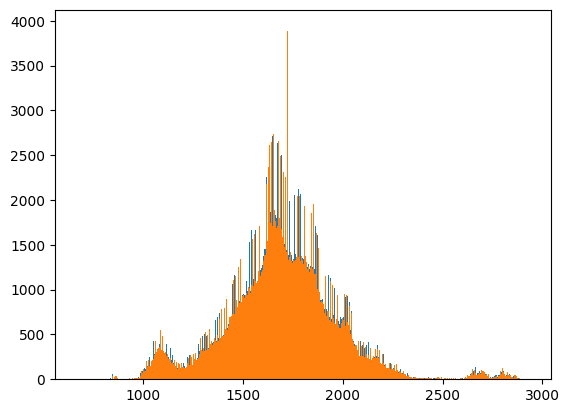

In [62]:
bins = 1000
plt.hist(data_array[:, 1], bins=bins, label='White ELO')
plt.hist(data_array[:, 2], bins=bins, label='Black ELO')
plt.show()

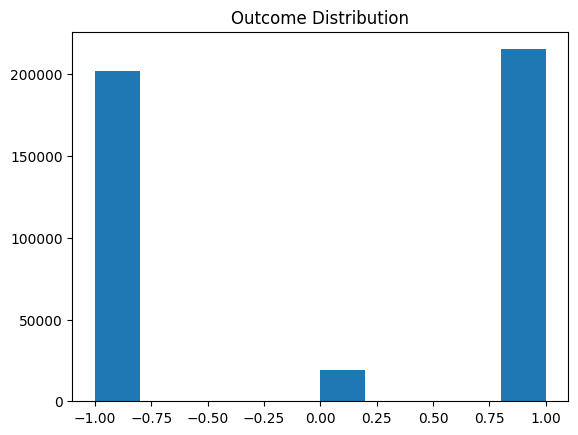

In [67]:
bins = 10
plt.hist(data_array[:, 0], bins=bins, label='Outcome')
plt.title('Outcome Distribution')
plt.show()

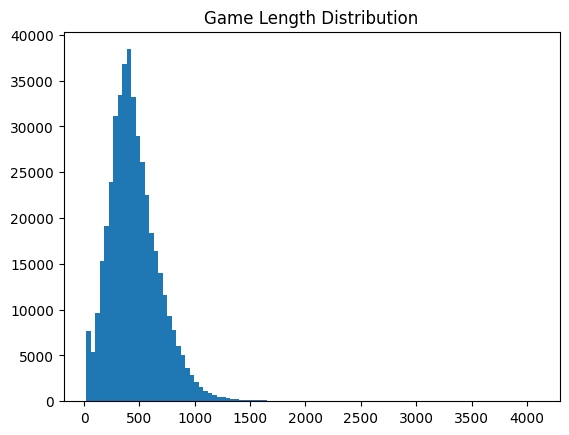

In [70]:
bins = 100
plt.hist(data_array[:, 3], bins=bins, label='Game Length')
plt.title('Game Length Distribution')
plt.show()

In [ ]:
def get_board_positions(game_moves):
    board = chess.Board()
    positions = []

    for move in game_moves:
        board.push_san(move)
        positions.append(board_to_array(board))

    return positions

def board_to_array(board):    
    arr = np.zeros(64, dtype=np.int8)
    for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece is not None:
                arr[square] = piece.piece_type * (1 if piece.color else -1)
    # arr = arr.reshape((8, 8))     # Need a reason to reshape
    return arr

In [25]:
positions = get_board_positions(moves_list[1000])

for position in positions:
    print(position)

[[ 4  2  3  5  6  3  2  4]
 [ 1  1  1  1  0  1  1  1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [-4 -2 -3 -5 -6 -3 -2 -4]]
[[ 4  2  3  5  6  3  2  4]
 [ 1  1  1  1  0  1  1  1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0 -1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [-1 -1  0 -1 -1 -1 -1 -1]
 [-4 -2 -3 -5 -6 -3 -2 -4]]
[[ 4  2  3  5  6  3  0  4]
 [ 1  1  1  1  0  1  1  1]
 [ 0  0  0  0  0  2  0  0]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0 -1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [-1 -1  0 -1 -1 -1 -1 -1]
 [-4 -2 -3 -5 -6 -3 -2 -4]]
[[ 4  2  3  5  6  3  0  4]
 [ 1  1  1  1  0  1  1  1]
 [ 0  0  0  0  0  2  0  0]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0 -1  0  0  0  0  0]
 [ 0  0 -2  0  0  0  0  0]
 [-1 -1  0 -1 -1 -1 -1 -1]
 [-4  0 -3 -5 -6 -3 -2 -4]]
[[ 4  2  3  5  6  3  0  4]
 [ 1  1  1  0  0  1  1  1]
 [ 0  0  0  0  0  2  0  0]
 [ 0  0  0  1  1  0  0  0]
 [ 0  0 -1  0  0  0  0  

In [ ]:
def depth_first_search(board):
    